In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Beta,Bernoulli,Categorical, MultivariateNormalDiag, Dirichlet, OneHotCategorical,Normal,MultivariateNormalFullCovariance,Mixture,ParamMixture
from edward.models.random_variables import TransformedDistribution
from scipy.stats import norm,lognorm
import math
import time
from build_dataset import build_dataset_1dim_gmm


In [2]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [3]:
def hist_point(N,x_data):
    hist = [[] for i in range(80)]
    point = np.array([[0.0]*N]*2,dtype=np.float32)
    width = 0.25
    height = 1.0/(width*N)
    for n in range(N):
        d=x_data[n]
        h=int((d-5.0)/width)
        hist[h].append(n)
        point[0][n]=5.0+h*width
        point[1][n]=(len(hist[h])-1)*height
    return point,width,height

<IPython.core.display.Javascript object>


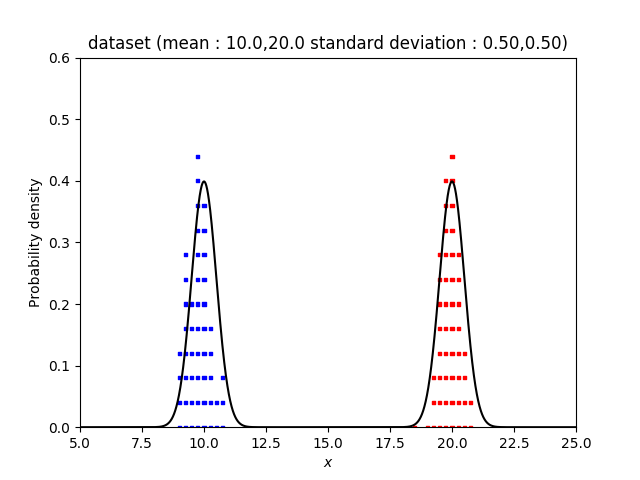

In [8]:
%matplotlib nbagg
N=100
mean_true = np.array([10.0,20.0])
std_true = np.array([0.5,0.5])
pi_true = np.array([0.5,0.5])

x_data,label =build_dataset_1dim_gmm(N,mean_true,std_true,pi_true)
point,width,height = hist_point(N,x_data)

area = [[5.0]*N]
grid = np.linspace(start=5.0,stop=25.0,num=10000)
plt.title("dataset (mean : {0:.1f},".format(mean_true[0]) +"{0:.1f} ".format(mean_true[1])+"standard deviation : {0:.2f},".format(std_true[0])+"{0:.2f})".format(std_true[1]))
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,0.6)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
color =[]
for t,p in enumerate(label):
    color.append([p,0.0,1.0-p])
plt.scatter(point[0],point[1],s=area,c=color,marker='s')
plt.show()
#plt.savefig("dataset_ex3.png")


In [41]:
import tensorflow as tf

var1 = tf.Variable(2.0)
holder2 = tf.placeholder(tf.float32)
add_op = tf.multiply(var1, holder2)
#update_var1 = tf.assign(var1, add_op)
#mul_op = tf.multiply(add_op, update_var1)

sess=ed.get_session()
tf.global_variables_initializer().run()

result = sess.run(add_op, feed_dict={holder2: 5})
print(result)

result = sess.run(add_op, feed_dict={holder2: 10})
print(result)

10.0
20.0


In [42]:
def gmm_bbvi_1dim_gmm_z_mu(N,x_data,n_iter,lambda_m0_init=10.0,lambda_m1_init=20.0):
    start = time.time()
    ds = tf.contrib.distributions
    #generative model 
    pi = 0.5
    mu0 = Normal(loc=tf.constant(10.0),scale=tf.constant(0.5))
    mu1 = Normal(loc=tf.constant(20.0),scale=tf.constant(0.5))
    z = [Bernoulli(probs = pi, dtype = tf.float32) for n in range(N)]
    x = [Normal(loc=mu0*(1.0-z[n])+mu1*z[n],scale=0.5) for n in range(N)]
    print("generative model")
    #variational model
    lambda_m0= tf.Variable(lambda_m0_init)
    lambda_m1= tf.Variable(lambda_m1_init)
    lambda_s0= tf.nn.softplus(tf.Variable(1.5))
    lambda_s1= tf.nn.softplus(tf.Variable(1.5))
    qmu0 = Normal(loc=lambda_m0, scale=lambda_s0) 
    qmu1= Normal(loc=lambda_m1, scale=lambda_s1) 

    x_ph = [tf.placeholder(tf.float32) for n in range(N)]
    a = tf.Variable(-1.0)
    b = tf.Variable(15.0)
    y = [tf.add(tf.multiply(a,x_ph[n]),b) for n in range(N)]
    lambda_z = [tf.nn.sigmoid(y[n]) for n in range(N)]
    qz = [Bernoulli(probs = lambda_z[n],dtype=tf.float32) for n in range(N)]
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[mu0]=qmu0
    latent_vars[mu1]=qmu1
    x_ph = [tf.placeholder(tf.float32) for n in range(N)]
    data = {x[n]:x_ph[n] for n in range(N)}

    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter,n_samples=1)
    print("inference")
    print(time.time()-start)
    sess=ed.get_session()
    tf.global_variables_initializer().run()
    loss = []
    variational_parameter = []
    variational_parameter.append(sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, a, b]))
    for _ in range(inference.n_iter):
            info_dict = inference.update(feed_dict={x_ph[n]:x_data[n] for n in range(N)})
            loss.append(info_dict['loss'])
            variational_parameter.append(sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, a, b]))
    print(time.time()-start)          
    return loss,variational_parameter

In [43]:
loss, variational_parameter = gmm_bbvi_1dim_gmm_z_mu(N,x_data,n_iter=2000,lambda_m0_init=8.0,lambda_m1_init=22.0 )

generative model
variational model
inference
45.21521806716919


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1318' with dtype float
	 [[Node: Placeholder_1318 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_1318', defined at:
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-8e410e242ee1>", line 1, in <module>
    loss, variational_parameter = gmm_bbvi_1dim_gmm_z_mu(N,x_data,n_iter=2000,lambda_m0_init=8.0,lambda_m1_init=22.0 )
  File "<ipython-input-42-861bd132d8b1>", line 19, in gmm_bbvi_1dim_gmm_z_mu
    x_ph = [tf.placeholder(tf.float32) for n in range(N)]
  File "<ipython-input-42-861bd132d8b1>", line 19, in <listcomp>
    x_ph = [tf.placeholder(tf.float32) for n in range(N)]
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1680, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3141, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1318' with dtype float
	 [[Node: Placeholder_1318 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


<IPython.core.display.Javascript object>


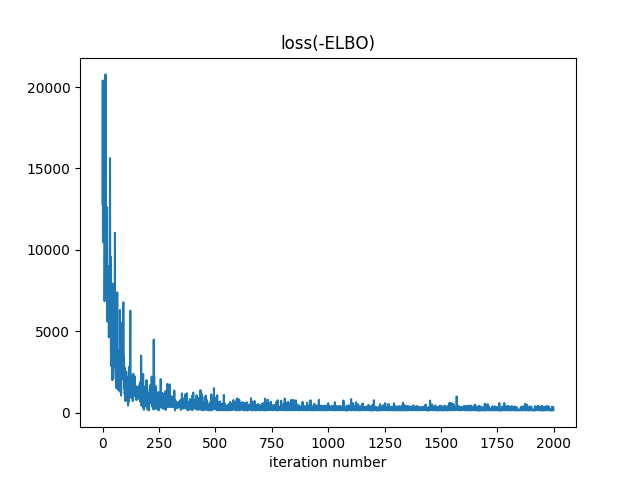

In [12]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()
#plt.savefig("loss_ex3.png")

<IPython.core.display.Javascript object>


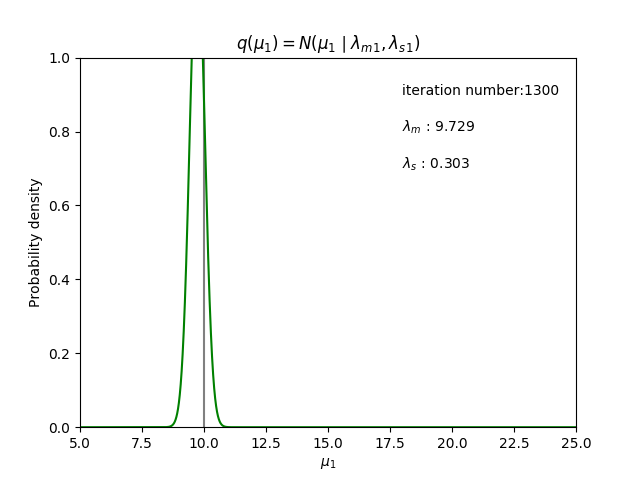

In [12]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_1)=N(\mu_1\mid{\lambda_m}_1,{\lambda_s}_1)$")
plt.xlabel("$\mu_1$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[0],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=vp[1]),color="green")
        text = [plt.text(18,0.9,"iteration number:"+str(t)),
                     plt.text(18,0.8,"$\lambda_m$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\lambda_s$ : {0:.3f}".format(vp[1]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu1_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


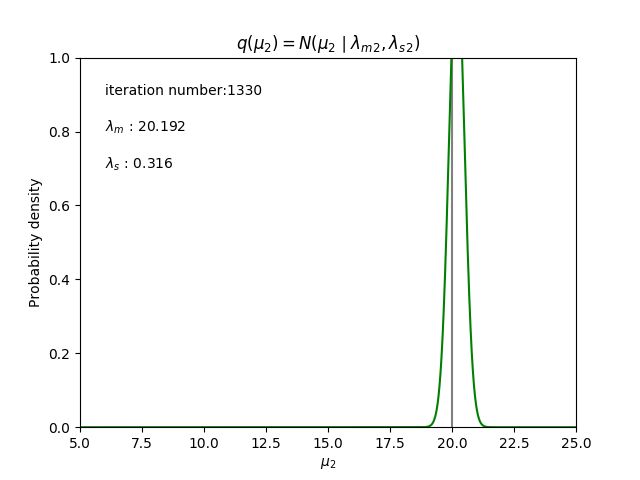

In [13]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_2)=N(\mu_2\mid{\lambda_m}_2,{\lambda_s}_2)$")
plt.xlabel("$\mu_2$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[1],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[2], scale=vp[3]),color="green")
        text = [plt.text(6,0.9,"iteration number:"+str(t)),
                     plt.text(6,0.8,"$\lambda_m$ : {0:.3f}".format(vp[2])),
                     plt.text(6,0.7,"$\lambda_s$ : {0:.3f}".format(vp[3]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu2_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


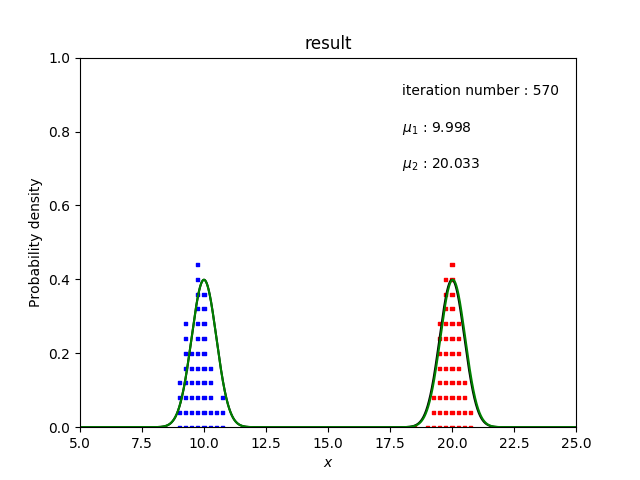

In [13]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("result")
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
area = [[5.0]*N]

artists = []
for t,vp in enumerate(variational_parameter):
    if t%5 == 0:
        im=plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=vp[2], scale=std_true[1])*pi_true[1],
                 color="green")
        color =[]
        for zn,p in enumerate(vp[4]):
            color.append([p,0.0,1.0-p])
        im_z=plt.scatter(point[0],point[1],s=area,c=color,marker='s')
        text = [plt.text(18,0.9,"iteration number : "+str(t)),
                     plt.text(18,0.8,"$\mu_1$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\mu_2$ : {0:.3f}".format(vp[2]))]
        artists.append(im+[im_z]+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("result_ex3.gif", writer='imagemagick', fps=4)